## Likelihood-free inference on MA2 using ABC-SMC
MA2 is the Moving Average of order 2 model. Here we demonstrate the ABC-SMC capabilities in Sciope.

In [1]:
import numpy as np
import sciope

from sciope.utilities.priors.uniform_prior import UniformPrior
from sciope.utilities.distancefunctions.euclidean import EuclideanDistance
from sciope.utilities.perturbationkernels.multivariate_normal import MultivariateNormalKernel
from sciope.utilities.epsilonselectors.relative_epsilon_selector import RelativeEpsilonSelector
from sciope.utilities.epsilonselectors.absolute_epsilon_selector import AbsoluteEpsilonSelector

from sciope.inference.abc_inference import ABC
from sciope.inference.smc_abc import SMCABC
from sciope.inference.rep_smc_abc import ReplenishmentSMCABC

import matplotlib.pyplot as plt

import logging
logger = logging.getLogger()
logger.setLevel(logging.ERROR)

In [2]:
def simulator(param, n=100):
    """
    Simulate a given parameter combination.

    Parameters
    ----------
    param : vector or 1D array
        Parameters to simulate (\theta).
    n : integer
        Time series length
    """
    m = len(param)
    g = np.random.normal(0, 1, n)
    gy = np.random.normal(0, 0.3, n)
    y = np.zeros(n)
    x = np.zeros(n)
    for t in range(0, n):
        x[t] += g[t]
        for p in range(0, np.minimum(t, m)):
            x[t] += g[t - 1 - p] * param[p]
        y[t] = x[t] + gy[t]
    
    return np.reshape(y, (1,1,100))

# Data
Synthetic observed data for true coefficents [0.6, 0.2]

In [3]:
obs_data = simulator([0.6,0.2]) 

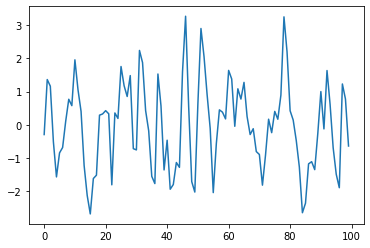

In [5]:
plt.plot(obs_data[0].T)

# Prior Distributions
Here we use a uniform prior on the parameters

In [6]:
parameter_names = ['k1', 'k2']

lower_bounds = [0, 0]
upper_bounds = [1, 1]

prior = UniformPrior(np.array(lower_bounds), np.array(upper_bounds))

# Summary Statistics and Distance Function

### Statistics and Euclidean Distance

In [7]:
distance_func = EuclideanDistance()

In [8]:
from sciope.utilities.summarystats import auto_tsfresh

default_fc_params = {
                     'variance':None,
                     'autocorrelation':
                         [{'lag':1},
                          {'lag':2}]}

summaries = auto_tsfresh.SummariesTSFRESH(features=default_fc_params)

In [9]:
#test
summaries.compute(simulator([0.1,0.2]))

array([[1.09750036, 0.20005798, 0.08539919]])

# Inference
For better the accuracy increase num_samples 

### Using ABC-SMC


In [10]:
from sciope.inference.smc_abc import SMCABC

In [11]:
max_rounds = 6
eps_selector = RelativeEpsilonSelector(20, max_rounds)

smcabc = SMCABC(obs_data, # Observed Dataset
          simulator, # Simulator method
          prior, # Prior
          summaries_function=summaries.compute
          )

%time smc_abc_results = smcabc.infer(num_samples = 100, batch_size = 1, chunk_size=1, eps_selector=eps_selector)

Determining initial population using 20
Starting epsilon = 0.371348778437286
Starting epsilon = 0.17368884702741821
Starting epsilon = 0.0922812516847447
Starting epsilon = 0.04487258552463505
Starting epsilon = 0.023966897414093604
CPU times: user 3min 14s, sys: 25.4 s, total: 3min 40s
Wall time: 3min 15s


## Plotting

In [30]:
posterior = np.array(smc_abc_results[-1]["accepted_samples"])

In [44]:
import matplotlib.pyplot as plt

def plot_posterior(posterior):
    true_params = [0.6, 0.2]
    fig, ax = plt.subplots(posterior.shape[1], posterior.shape[1], facecolor = 'w')
    for i in range(posterior.shape[1]):
        for j in range(posterior.shape[1]):
            if i > j:
                ax[i,j].axis('off')
            else:
                if i == j:
                    ax[i,j].hist(posterior[:,i], bins = 'auto')
                    ax[i,j].axvline(np.median(posterior[:,i]), color = 'C1')
                    #ax[i,j].axvline(np.log(true_params[i]))
                    ax[i,j].set_xlim(lower_bounds[i], upper_bounds[i])
                else:
                    ax[i,j].scatter(posterior[:,j], posterior[:,i])
                    ax[i,j].set_ylim(lower_bounds[i], upper_bounds[i])
                    ax[i,j].set_xlim(lower_bounds[j], upper_bounds[j])
        ax[i,0].set_ylabel(parameter_names[i])
        ax[0,i].set_title(parameter_names[i])
    fig.set_size_inches(10,10)
    fig.tight_layout()

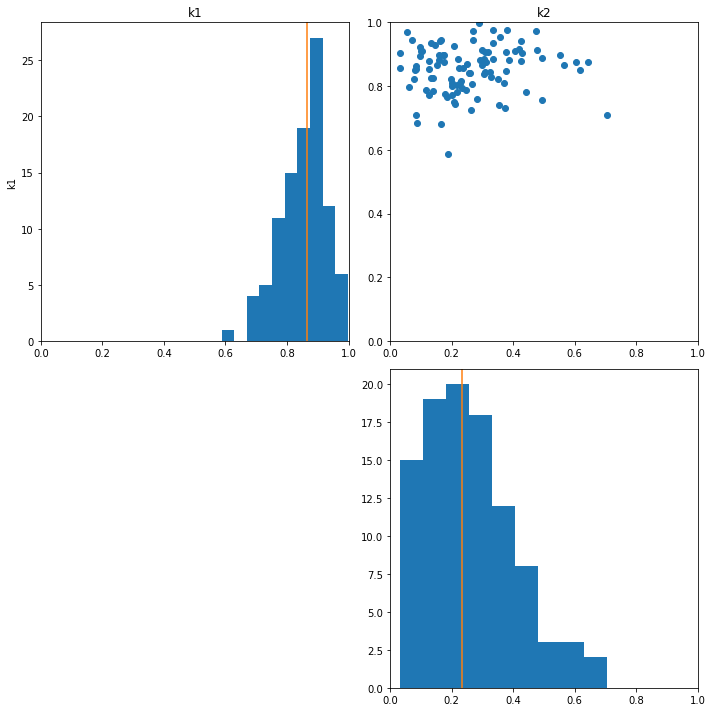

In [45]:
plot_posterior(posterior)

## Using Replenishment ABC-SMC

In [42]:
repsmcabc = ReplenishmentSMCABC(obs_data,
                                simulator,
                                prior,
                                summaries_function=summaries.compute
                               )
repsmcabc.compute_fixed_mean(1)

In [43]:
%time rsmc_abc_results = repsmcabc.infer(num_samples = 100, batch_size = 1)

Tol : 0.5575376994578254, R : 10, p_acc : 0.38400000000000006
Tol : 0.38720725744577617, R : 13, p_acc : 0.5466666666666666
Tol : 0.2556123022317292, R : 24, p_acc : 0.36771428571428577
Tol : 0.17529900512292929, R : 37, p_acc : 0.23059259259259257
Tol : 0.1365253579635279, R : 60, p_acc : 0.1476
Tol : 0.10426099144110716, R : 107, p_acc : 0.08282474226804123
Tol : 0.0794333217104996, R : 207, p_acc : 0.04565482233502538
CPU times: user 28.6 s, sys: 1.86 s, total: 30.5 s
Wall time: 28.3 s


In [49]:
posterior = np.array(rsmc_abc_results["accepted_samples"])

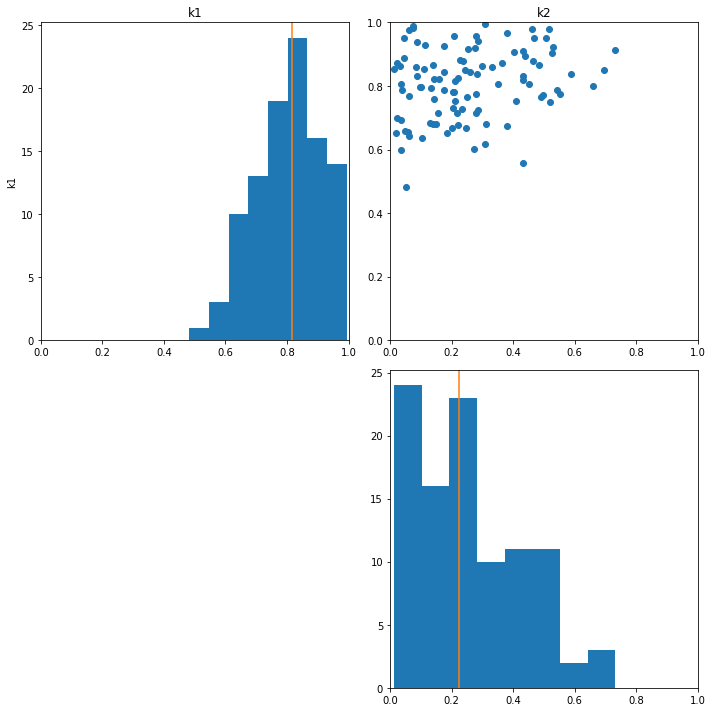

In [50]:
plot_posterior(posterior)